In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from matplotlib import pyplot as plt

DATASET_ROOT = './CroppedYale/'
SPLIT_P = 35

In [2]:
# Construct filepaths.
label_name = sorted(next(os.walk(DATASET_ROOT))[1])

In [3]:
# Load images and split into train/val sets.
X_train, X_test, Y_train, Y_test = [], [], [], []
for id_, name in tqdm(enumerate(label_name), total=len(label_name)):
    img_paths = glob.glob(DATASET_ROOT+name+'/*.pgm') # requirement of assignment 1
    np.random.shuffle(img_paths)
    train_paths, test_paths = img_paths[:SPLIT_P], img_paths[SPLIT_P:]
    X_train.extend([imread(img_path, as_grey=True) for img_path in train_paths])
    Y_train.extend([id_]*len(train_paths))
    X_test.extend([imread(img_path, as_grey=True) for img_path in test_paths])
    Y_test.extend([id_]*len(test_paths))
X_train, X_test, Y_train, Y_test = list(map(np.array, [X_train, X_test, Y_train, Y_test]))

100%|██████████| 38/38 [00:00<00:00, 82.70it/s]


In [4]:
# Define SSD, SAD
SSD = lambda x, y: np.sum(np.square(x-y), axis=(1, 2)) # args: (element, set of images) output shape: (n_img,)
SAD = lambda x, y: np.sum(np.abs(x-y), axis=(1, 2))

In [5]:
# Define nearest neighbor
NN = lambda p, Q, L, D: L[np.argmin(D(p, Q), axis=0)] # args: instance, train set, train label, distance method
def SSD_NN(x): return NN(x, X_train, Y_train, SSD) # Don't use lambda due to pickle error
def SAD_NN(x): return NN(x, X_train, Y_train, SAD)

In [6]:
import multiprocessing # faster NN
cpu_n = multiprocessing.cpu_count()
if __name__ == '__main__': 
    p = multiprocessing.Pool(cpu_n)
    Y_test_pred_ssd = np.array([p.map(SSD_NN, X_test)])
    Y_test_pred_sad = np.array([p.map(SAD_NN, X_test)])

In [7]:
print('SSD acc: %.2f%%'%(np.mean(Y_test_pred_ssd == Y_test)*100.))
print('SAD acc: %.2f%%'%(np.mean(Y_test_pred_sad == Y_test)*100.))

SSD acc: 60.00%
SAD acc: 31.61%


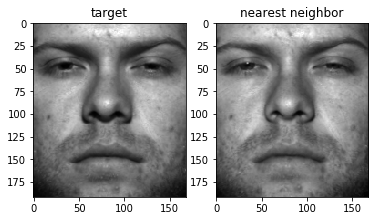

In [8]:
index = np.random.randint(0, len(Y_test))
nn = X_train[np.argmin(SSD(X_test[index], X_train), axis=0)]
plt.figure()
plt.subplot(1,2,1)
plt.title('target')
plt.imshow(X_test[index], cmap='gray')
plt.subplot(1,2,2)
plt.title('nearest neighbor')
plt.imshow(nn, cmap='gray')